In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt 
import time

In [2]:
from keras.preprocessing.image import ImageDataGenerator
train_dataset = ImageDataGenerator(rescale=1./255)
test_dataset = ImageDataGenerator(rescale=1./255)
validation_dataset = ImageDataGenerator(rescale=1./255)

batchsize = 10
train_generator=train_dataset.flow_from_directory('lagupdated_newfilter/train/', 
                                                  target_size=(224, 224), 
                                                  batch_size=batchsize, 
                                                  class_mode='categorical')
 
validation_generator = validation_dataset.flow_from_directory('lagupdated_newfilter/val/',
        target_size=(224, 224),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
test_generator = test_dataset.flow_from_directory('lagupdated_newfilter/test/',
       target_size=(224, 224),
       batch_size=batchsize,
       class_mode='categorical',
       shuffle=False)

Found 3420 images belonging to 2 classes.
Found 972 images belonging to 2 classes.
Found 472 images belonging to 2 classes.


In [3]:
#DenseNet121
base_model1=keras.applications.DenseNet121(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)

#VGG19
base_model3=keras.applications.vgg19.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#MobileNet
base_model4=tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#ResNet50 
base_model5 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax')

#Inception V3
base_model6=tf.keras.applications.InceptionV3(
    include_top=True, weights="imagenet", input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation="softmax",
)




In [4]:
for layer in base_model1.layers:
    layer.trainable=False
for layer in base_model3.layers:
    layer.trainable=False
for layer in base_model4.layers:
    layer.trainable=False
for layer in base_model5.layers:
    layer.trainable=False
for layer in base_model6.layers:
    layer.trainable=False
    

In [5]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

In [6]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1)):   
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides)(x)
    x = Lambda(swish)(x)
    x = BatchNormalization(axis=3)(x)  
    return x

In [7]:
def Inception(x,nb_filter):  
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
  
    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1))  
  
    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
  
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)  
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1))  
  
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)    
    return x

In [8]:
#DenseNet169
x = base_model1.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_1 = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions_1)

In [9]:
#VGG-19
x = base_model3.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_3 = Dense(2, activation='softmax')(x)
model3 = Model(inputs=base_model3.input, outputs=predictions_3)

In [10]:
#MobileNet V2
x = base_model4.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_4 = Dense(2, activation='softmax')(x)
model4 = Model(inputs=base_model4.input, outputs=predictions_4)

In [11]:
#ResNet 50
x = base_model5.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_5 = Dense(2, activation='softmax')(x)
model5 = Model(inputs=base_model5.input, outputs=predictions_5)

In [12]:
#Inception V3
x = base_model6.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_6 = Dense(2, activation='softmax')(x)
model6 = Model(inputs=base_model6.input, outputs=predictions_6)

In [13]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

                                                                                                  
 conv2d_96 (Conv2D)             (None, 7, 7, 512)    262656      ['max_pooling2d_4[0][0]']        
                                                                                                  
 conv2d_99 (Conv2D)             (None, 7, 7, 512)    2359808     ['batch_normalization_98[0][0]'] 
                                                                                                  
 lambda_2 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_96[0][0]']              
                                                                                                  
 lambda_5 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_99[0][0]']              
                                                                                                  
 batch_normalization_96 (BatchN  (None, 7, 7, 512)   2048        ['lambda_2[0][0]']               
 ormalizat

 lambda_10 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_104[0][0]']             
                                                                                                  
 lambda_13 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_107[0][0]']             
                                                                                                  
 lambda_14 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_108[0][0]']             
                                                                                                  
 batch_normalization_102 (Batch  (None, 7, 7, 512)   2048        ['lambda_8[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 7, 7, 512)   2048        ['lambda_10[0][0]']              
 Normaliza

In [14]:
learning_rate=0.0001
decay=1e-6
momentum=0.8
nesterov=True
sgd_optimizer= SGD(lr = learning_rate, decay = decay, momentum = momentum, nesterov = nesterov)

model1.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy'])

D:\Anaconda\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Tuning

In [15]:
base_model1.trainable = True
base_model3.trainable = True
base_model4.trainable = True
base_model5.trainable = True
base_model6.trainable = True

In [16]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model1.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model3.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model4.layers[:fine_tune_at]:
    layer.trainable = False


for layer in base_model5.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model6.layers[:fine_tune_at]:
    layer.trainable = False



In [17]:
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10),
              metrics=['accuracy'])

In [18]:
def comp():
    learning_rate=0.0001
    decay=1e-6
    momentum=0.8
    nesterov=True
    sgd_optimizer= SGD(lr = learning_rate, decay = decay, momentum = momentum, nesterov = nesterov)
    models=['VGG-19','MobileNet','ResNet50','Inception']
    
    for i in models:
        if i=='VGG-19':
            model3.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy'])
        elif i=='MobileNet':
            model4.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy'])
        elif i=='ResNet50':
            model5.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy'])
        else:
            model6.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy'])

        
if __name__ == "__main__":
    comp()

In [13]:
#DenseNet169
import time
epochs =50
batch_size = 10

start = time.time()
history_1 = model1.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50


D:\Anaconda\envs\tf-gpu\lib\site-packages\keras\backend.py:5674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


342/342 [==============================] - 105s 213ms/step - loss: 0.3994 - accuracy: 0.8269 - val_loss: 0.6000 - val_accuracy: 0.6430
Epoch 2/50
342/342 [==============================] - 69s 201ms/step - loss: 0.2256 - accuracy: 0.9082 - val_loss: 0.2148 - val_accuracy: 0.9177
Epoch 3/50
342/342 [==============================] - 69s 201ms/step - loss: 0.1554 - accuracy: 0.9427 - val_loss: 0.2412 - val_accuracy: 0.9228
Epoch 4/50
342/342 [==============================] - 69s 201ms/step - loss: 0.0849 - accuracy: 0.9708 - val_loss: 0.2348 - val_accuracy: 0.9321
Epoch 5/50
342/342 [==============================] - 69s 201ms/step - loss: 0.0964 - accuracy: 0.9708 - val_loss: 0.2017 - val_accuracy: 0.9352
Epoch 6/50
342/342 [==============================] - 70s 204ms/step - loss: 0.0480 - accuracy: 0.9839 - val_loss: 0.2797 - val_accuracy: 0.9342
Epoch 7/50
342/342 [==============================] - 70s 204ms/step - loss: 0.0703 - accuracy: 0.9784 - val_loss: 0.2092 - val_accuracy: 0.

In [17]:
model1.save('SavedModels/LAG updated/D121 Tuned.h5')

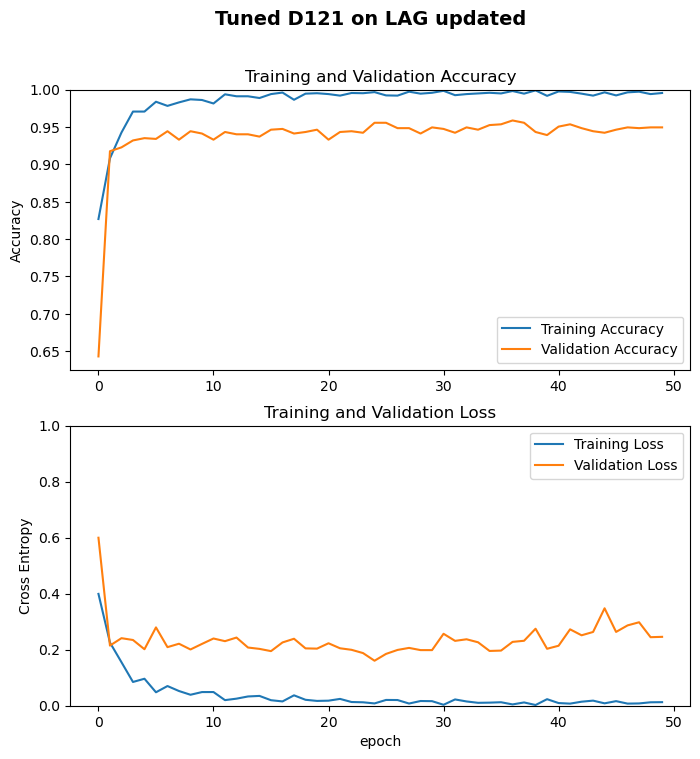

In [14]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('Tuned D121 on LAG updated', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
start=time.time()
test_output_1= model1.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_1)
print("testing time : "+ str(end-start))

47/47 [==============================] - 3s 63ms/step - loss: 0.1889 - accuracy: 0.9555
['loss', 'accuracy']
[0.18890158832073212, 0.9555084705352783]
testing time : 3.0627336502075195


In [16]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model1.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 5s 62ms/step
Confusion Matrix
[[147  14]
 [  7 304]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.95      0.91      0.93       161
      Normal       0.96      0.98      0.97       311

    accuracy                           0.96       472
   macro avg       0.96      0.95      0.95       472
weighted avg       0.96      0.96      0.96       472



Text(0.5, 23.52222222222222, 'Predicted label')

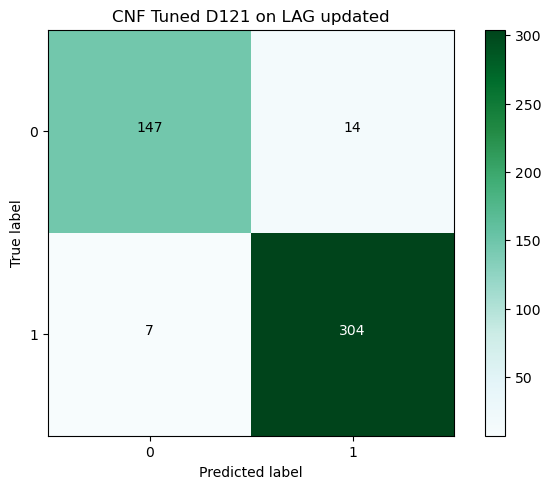

In [17]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF Tuned D121 on LAG updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [19]:
#Vgg-19
import time
epochs =50
batch_size = 10

start = time.time()
history_3 = model3.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 106s 291ms/step - loss: 0.4940 - accuracy: 0.7681 - val_loss: 0.6331 - val_accuracy: 0.5854
Epoch 2/50
342/342 [==============================] - 98s 287ms/step - loss: 0.3820 - accuracy: 0.8459 - val_loss: 0.3777 - val_accuracy: 0.8488
Epoch 3/50
342/342 [==============================] - 98s 287ms/step - loss: 0.3366 - accuracy: 0.8690 - val_loss: 0.3173 - val_accuracy: 0.8776
Epoch 4/50
342/342 [==============================] - 98s 287ms/step - loss: 0.3099 - accuracy: 0.8772 - val_loss: 0.2809 - val_accuracy: 0.8940
Epoch 5/50
342/342 [==============================] - 98s 287ms/step - loss: 0.2939 - accuracy: 0.8839 - val_loss: 0.2738 - val_accuracy: 0.9012
Epoch 6/50
342/342 [==============================] - 98s 287ms/step - loss: 0.2727 - accuracy: 0.9000 - val_loss: 0.2498 - val_accuracy: 0.9043
Epoch 7/50
342/342 [==============================] - 98s 287ms/step - loss: 0.2559 - accuracy: 0.9079 - val_loss: 0.2400 - val_a

In [25]:
model3.save('SavedModels/LAG newfilter/VGG19Tuned.h5')

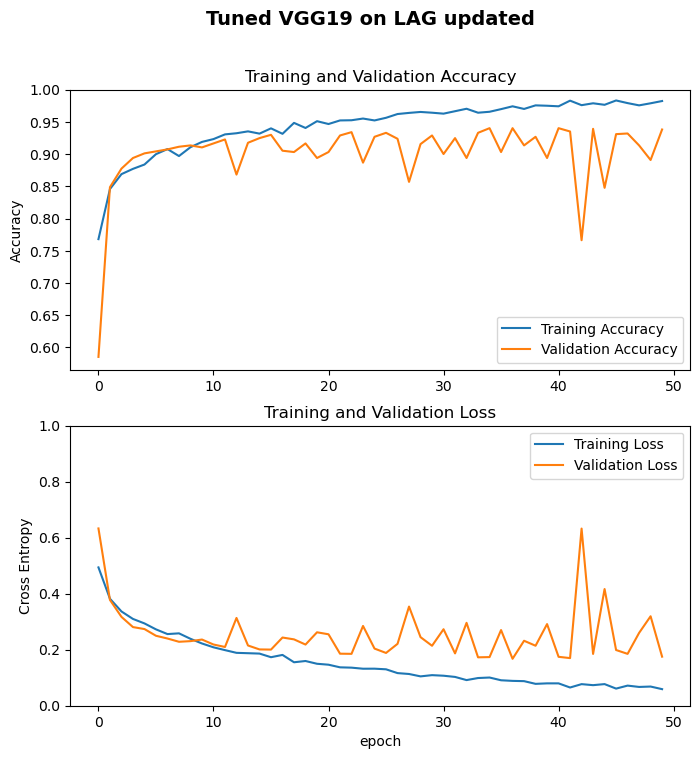

In [20]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('Tuned VGG19 on LAG updated', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
start=time.time()
test_output_3= model3.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model3.metrics_names)
print(test_output_3)
print("testing time : "+ str(end-start))

47/47 [==============================] - 8s 160ms/step - loss: 0.1909 - accuracy: 0.9364
['loss', 'accuracy']
[0.19087089598178864, 0.9364407062530518]
testing time : 7.928940057754517


In [22]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model3.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 8s 158ms/step
Confusion Matrix
[[145  16]
 [ 14 297]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.91      0.90      0.91       161
      Normal       0.95      0.95      0.95       311

    accuracy                           0.94       472
   macro avg       0.93      0.93      0.93       472
weighted avg       0.94      0.94      0.94       472



Text(0.5, 23.52222222222222, 'Predicted label')

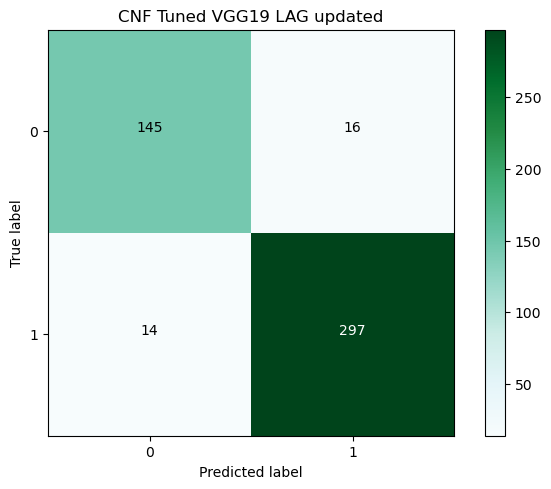

In [23]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF Tuned VGG19 LAG updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [24]:
#MobileNet 
import time
epochs =50
batch_size = 10

start = time.time()
history_4 = model4.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 38s 99ms/step - loss: 0.4995 - accuracy: 0.7512 - val_loss: 0.4730 - val_accuracy: 0.7881
Epoch 2/50
342/342 [==============================] - 32s 94ms/step - loss: 0.3533 - accuracy: 0.8474 - val_loss: 0.4000 - val_accuracy: 0.8230
Epoch 3/50
342/342 [==============================] - 32s 94ms/step - loss: 0.2870 - accuracy: 0.8833 - val_loss: 0.3486 - val_accuracy: 0.8508
Epoch 4/50
342/342 [==============================] - 32s 94ms/step - loss: 0.2472 - accuracy: 0.9041 - val_loss: 0.3010 - val_accuracy: 0.8765
Epoch 5/50
342/342 [==============================] - 32s 94ms/step - loss: 0.2017 - accuracy: 0.9208 - val_loss: 0.2731 - val_accuracy: 0.8848
Epoch 6/50
342/342 [==============================] - 32s 95ms/step - loss: 0.1692 - accuracy: 0.9427 - val_loss: 0.2484 - val_accuracy: 0.9002
Epoch 7/50
342/342 [==============================] - 32s 94ms/step - loss: 0.1519 - accuracy: 0.9462 - val_loss: 0.2376 - val_accuracy:

In [26]:
model4.save('SavedModels/LAG newfilter/MobileNetTuned.h5')

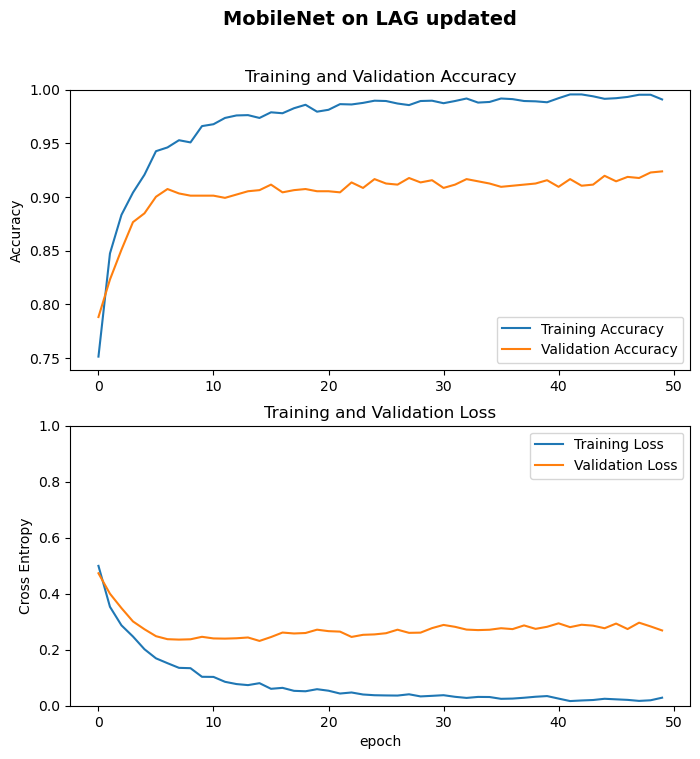

In [27]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('MobileNet on LAG updated', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
start=time.time()
test_output_4= model4.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model4.metrics_names)
print(test_output_4)
print("testing time : "+ str(end-start))

47/47 [==============================] - 2s 36ms/step - loss: 0.2590 - accuracy: 0.9364
['loss', 'accuracy']
[0.2590213119983673, 0.9364407062530518]
testing time : 1.7621781826019287


In [29]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model4.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 2s 33ms/step
Confusion Matrix
[[144  17]
 [ 13 298]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.92      0.89      0.91       161
      Normal       0.95      0.96      0.95       311

    accuracy                           0.94       472
   macro avg       0.93      0.93      0.93       472
weighted avg       0.94      0.94      0.94       472



Text(0.5, 23.52222222222222, 'Predicted label')

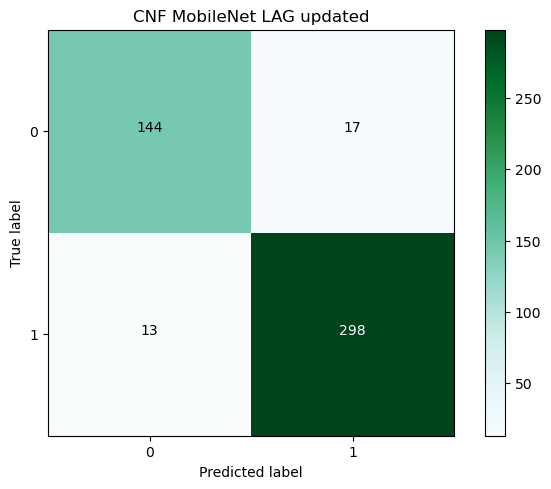

In [30]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF MobileNet LAG updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [30]:
#ResNet 50
import time
epochs =50
batch_size = 10

start = time.time()
history_5 = model5.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 138s 387ms/step - loss: 0.5389 - accuracy: 0.7333 - val_loss: 0.6599 - val_accuracy: 0.7140
Epoch 2/50
342/342 [==============================] - 131s 382ms/step - loss: 0.4571 - accuracy: 0.7924 - val_loss: 0.4757 - val_accuracy: 0.8272
Epoch 3/50
342/342 [==============================] - 131s 383ms/step - loss: 0.4203 - accuracy: 0.8184 - val_loss: 0.3904 - val_accuracy: 0.8004
Epoch 4/50
342/342 [==============================] - 131s 383ms/step - loss: 0.3817 - accuracy: 0.8336 - val_loss: 0.7257 - val_accuracy: 0.6389
Epoch 5/50
342/342 [==============================] - 131s 383ms/step - loss: 0.3659 - accuracy: 0.8442 - val_loss: 0.6637 - val_accuracy: 0.5422
Epoch 6/50
342/342 [==============================] - 131s 383ms/step - loss: 0.3570 - accuracy: 0.8488 - val_loss: 3.1271 - val_accuracy: 0.3632
Epoch 7/50
342/342 [==============================] - 131s 383ms/step - loss: 0.3302 - accuracy: 0.8617 - val_loss: 0.5614 -

In [31]:
model5.save('SavedModels/LAG updated/ResNetTuned.h5')

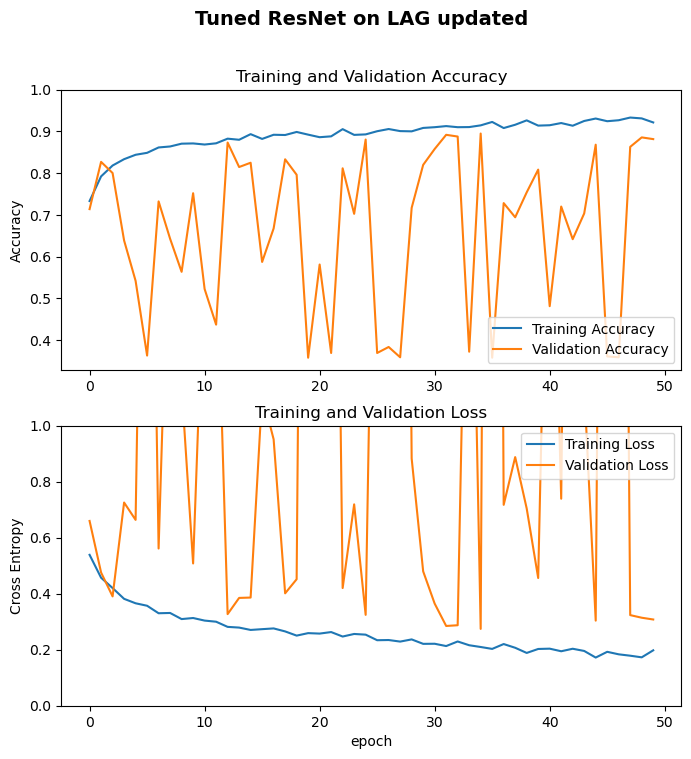

In [32]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle('Tuned ResNet on LAG updated', fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
start=time.time()
test_output_5= model5.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model5.metrics_names)
print(test_output_5)
print("testing time : "+ str(end-start))

47/47 [==============================] - 7s 153ms/step - loss: 0.2952 - accuracy: 0.8898
['loss', 'accuracy']
[0.29520177841186523, 0.8898305296897888]
testing time : 7.310028553009033


In [34]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model5.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 8s 145ms/step
Confusion Matrix
[[147  14]
 [ 38 273]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.79      0.91      0.85       161
      Normal       0.95      0.88      0.91       311

    accuracy                           0.89       472
   macro avg       0.87      0.90      0.88       472
weighted avg       0.90      0.89      0.89       472



Text(0.5, 23.52222222222222, 'Predicted label')

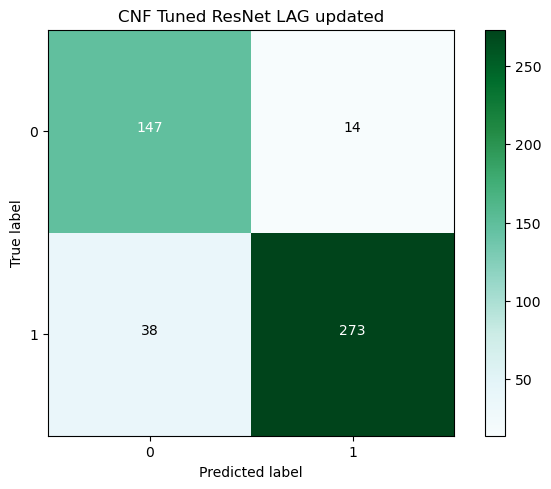

In [35]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF Tuned ResNet LAG updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [36]:
#Inception V3
import time
epochs =50
batch_size = 10

start = time.time()
history_6 = model6.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
342/342 [==============================] - 69s 181ms/step - loss: 0.5612 - accuracy: 0.7079 - val_loss: 0.4634 - val_accuracy: 0.7912
Epoch 2/50
342/342 [==============================] - 60s 175ms/step - loss: 0.3965 - accuracy: 0.8202 - val_loss: 0.4573 - val_accuracy: 0.7953
Epoch 3/50
342/342 [==============================] - 60s 175ms/step - loss: 0.3060 - accuracy: 0.8690 - val_loss: 0.3668 - val_accuracy: 0.8560
Epoch 4/50
342/342 [==============================] - 60s 175ms/step - loss: 0.2521 - accuracy: 0.8965 - val_loss: 0.3416 - val_accuracy: 0.8652
Epoch 5/50
342/342 [==============================] - 60s 175ms/step - loss: 0.2309 - accuracy: 0.9088 - val_loss: 0.3550 - val_accuracy: 0.8601
Epoch 6/50
342/342 [==============================] - 60s 176ms/step - loss: 0.1828 - accuracy: 0.9313 - val_loss: 0.3364 - val_accuracy: 0.8693
Epoch 7/50
342/342 [==============================] - 60s 175ms/step - loss: 0.1467 - accuracy: 0.9465 - val_loss: 0.3371 - val_ac

In [37]:
model6.save('SavedModels/LAG updated/Inception Tuned.h5')

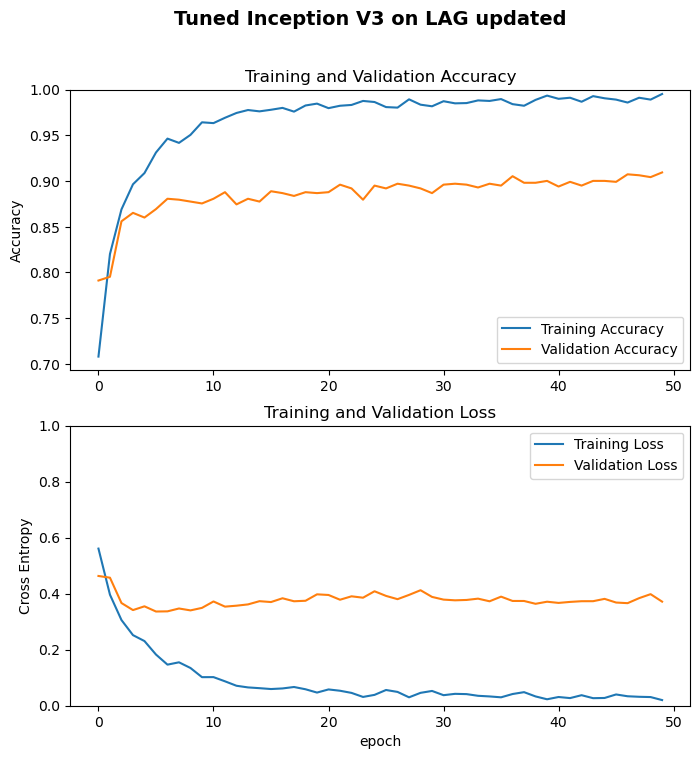

In [38]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.suptitle("Tuned Inception V3 on LAG updated", fontsize=14, fontweight='bold')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
start=time.time()
test_output_6= model6.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model6.metrics_names)
print(test_output_6)
print("testing time : "+ str(end-start))

47/47 [==============================] - 3s 63ms/step - loss: 0.3844 - accuracy: 0.9089
['loss', 'accuracy']
[0.3843773603439331, 0.9088982939720154]
testing time : 3.074913263320923


In [40]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model6.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

48/48 [==============================] - 4s 57ms/step
Confusion Matrix
[[134  27]
 [ 16 295]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.89      0.83      0.86       161
      Normal       0.92      0.95      0.93       311

    accuracy                           0.91       472
   macro avg       0.90      0.89      0.90       472
weighted avg       0.91      0.91      0.91       472



Text(0.5, 23.52222222222222, 'Predicted label')

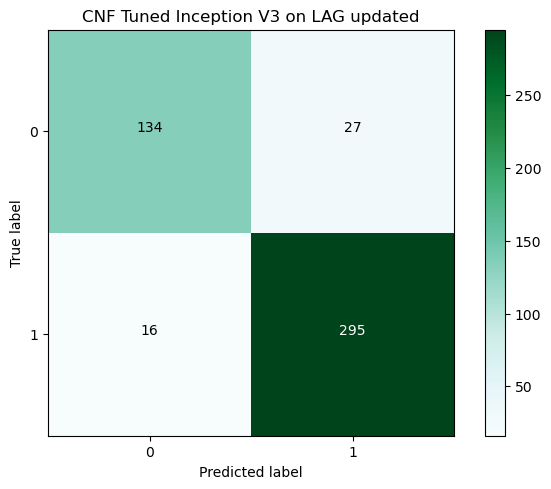

In [41]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("CNF Tuned Inception V3 on LAG updated")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')